In [51]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imagehash
import seaborn as sns
import torch
import cv2
from tqdm import tqdm 
import os

sns.set_style('darkgrid')

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **1. Dataset Analysis and Dataset Cleaning**

In [52]:
def find_duplicates_across_splits(train_dir, test_dir):
    train_hashes = {}
    for img_path in tqdm(os.listdir(train_dir)):
        if img_path.endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(train_dir, img_path)
            try:
                with Image.open(full_path) as img:
                    img_hash = str(imagehash.average_hash(img))
                    train_hashes[img_hash] = full_path
            except Exception as e:
                print(f"Ошибка обработки {full_path}: {e}")
    
    duplicates = []
    for img_path in tqdm(os.listdir(test_dir)):
        if img_path.endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(test_dir, img_path)
            try:
                with Image.open(full_path) as img:
                    test_hash = str(imagehash.average_hash(img))
                    if test_hash in train_hashes:
                        duplicates.append((full_path, train_hashes[test_hash]))
            except Exception as e:
                print(f"Ошибка обработки {full_path}: {e}")
    
    return duplicates

In [53]:
train_images_dir = './dataset/train/images'
val_images_dir = './dataset/val/images'
test_images_dir = './dataset/test/images'

train_val_duplicates = find_duplicates_across_splits(train_images_dir, val_images_dir)
train_test_duplicates = find_duplicates_across_splits(train_images_dir, test_images_dir)
val_test_duplicates = find_duplicates_across_splits(val_images_dir, test_images_dir)

100%|███████████████████████████████████████| 450/450 [00:00<00:00, 1208.35it/s]


In [54]:
if train_val_duplicates:
    print(f"Найдено {len(train_val_duplicates)} повторяющихся изображений между train и val")
if train_test_duplicates:
    print(f"Найдено {len(train_test_duplicates)} повторяющихся изображений между train и test")
if val_test_duplicates:
    print(f"Найдено {len(val_test_duplicates)} повторяющихся изображений между val и test")

Найдено 37 повторяющихся изображений между train и val
Найдено 20 повторяющихся изображений между train и test
Найдено 6 повторяющихся изображений между val и test


In [55]:
def show_duplicates(test_path, train_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    test_img = Image.open(test_path)
    ax1.imshow(test_img)
    ax1.set_title(f'SPLIT1: {test_path.split("/")[-1]}', size=10)
    ax1.axis('off')
    
    train_img = Image.open(train_path)
    ax2.imshow(train_img)
    ax2.set_title(f'SPLIT2: {train_path.split("/")[-1]}', size=10)
    ax2.axis('off')
    
    plt.tight_layout();

In [56]:
def show_duplicates_for_split(duplicaces, n):
    for split1_img, split2_img in duplicaces[:n]:
        show_duplicates(split1_img, split2_img)

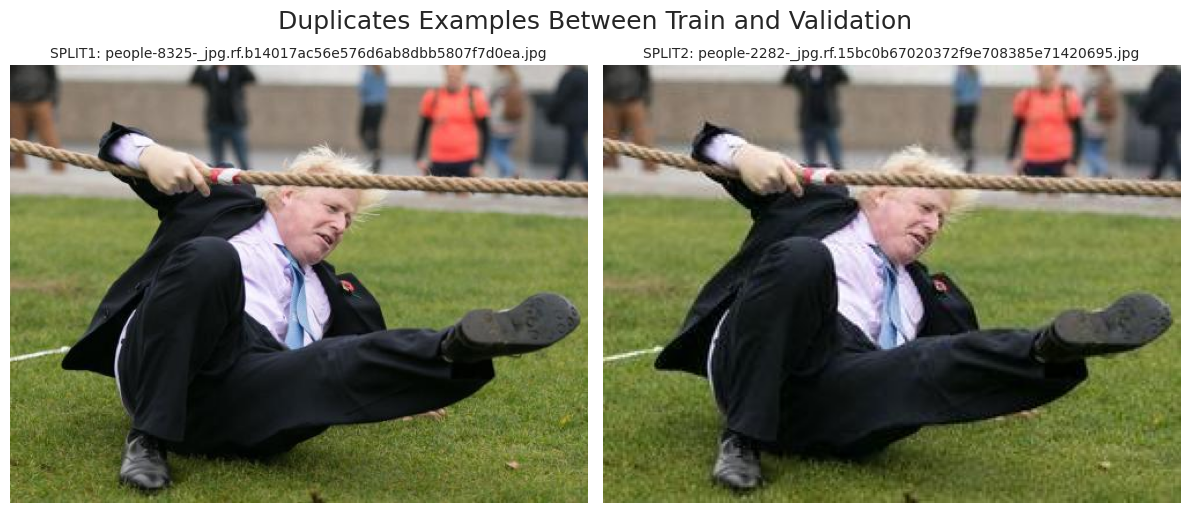

In [57]:
show_duplicates_for_split(train_val_duplicates, 1)
plt.suptitle('Duplicates Examples Between Train and Validation', y=1.05, size=18);

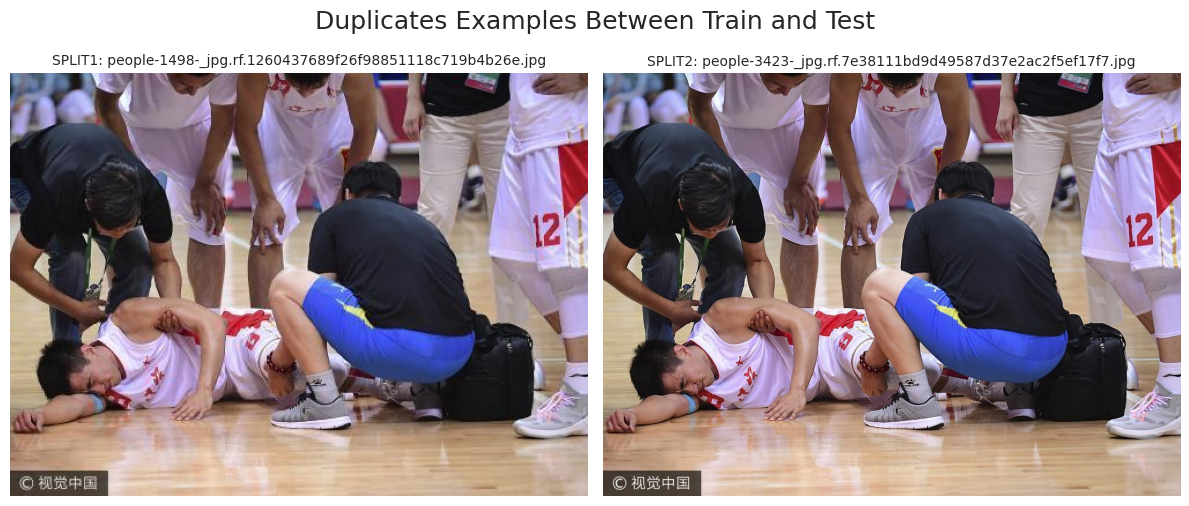

In [58]:
show_duplicates_for_split(train_test_duplicates, 1)
plt.suptitle('Duplicates Examples Between Train and Test', y=1.05, size=18);

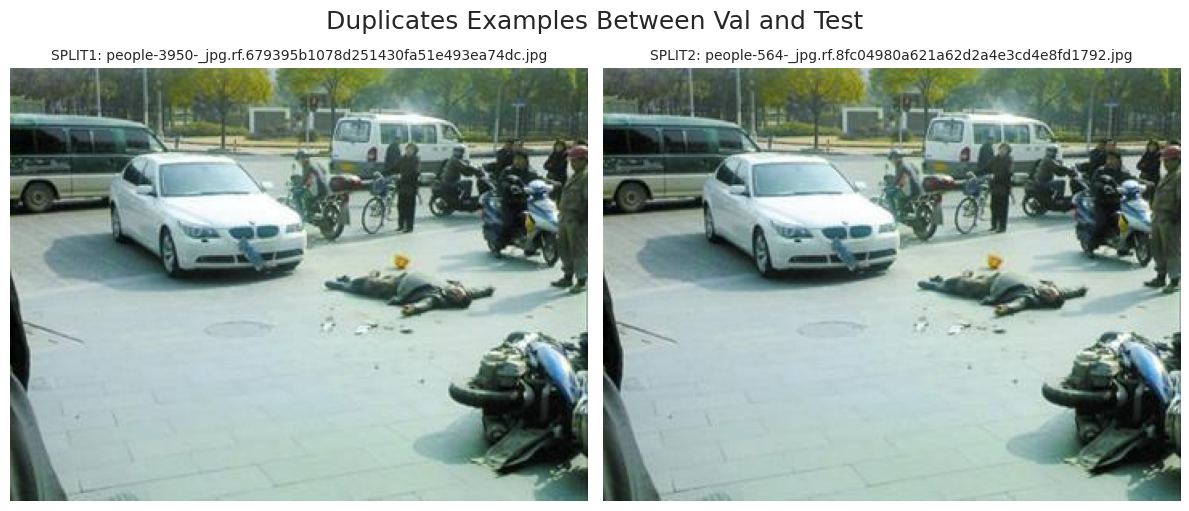

In [59]:
show_duplicates_for_split(val_test_duplicates, 1)
plt.suptitle('Duplicates Examples Between Val and Test', y=1.05, size=18);

In [60]:
def clean_dataset(duplicates):
    removed_files = []
    
    for file_to_remove, file_to_keep in duplicates:
        if not os.path.exists(file_to_remove):
            print(f"Файл не существует, пропускаем: {file_to_remove}")
            continue
        
        os.remove(file_to_remove)
        
        txt_to_remove = file_to_remove.replace('/images/', '/labels/').rsplit('.', 1)[0] + '.txt'
        if os.path.exists(txt_to_remove):
            os.remove(txt_to_remove)
        
        removed_files.append((file_to_remove, file_to_keep))

    print(f'Удалено {len(removed_files)} файлов')
    return removed_files

In [61]:
train_val_deleted = clean_dataset(train_val_duplicates)

Удалено 37 файлов


In [62]:
train_test_deleted = clean_dataset(train_test_duplicates)

Удалено 20 файлов


In [63]:
val_test_deleted = clean_dataset(val_test_duplicates)

Удалено 6 файлов


# **2. YOLOv11 Training**

In [65]:
model = YOLO('./models/yolo11n.pt')

In [ ]:
results = model.train(
    data="./dataset/data.yaml",
    epochs=150,
    imgsz=640,
    batch=16,
    device='cuda',
    verbose=False,
    pretrained=True,
    val=True,
    patience=20,       
    save_period=10,     
    plots=True,

    augment=True,          
    mosaic=1,            
    mixup=0.1,            
    degrees=10.0,         
    translate=0.25,
)

New https://pypi.org/project/ultralytics/8.3.202 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.201 🚀 Python-3.9.23 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./dataset/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=./models/yolo11n.pt, momentum=0.937, mosaic=1, multi_scale=False, name=train2, nbs=64, nms=False,

In [3]:
best_model = YOLO('./runs/detect/train/weights/best.pt')

In [ ]:
from ultralytics.yolo.utils.plotting import plot_results

plot_results('runs/train/exp/results.csv')